In [38]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import ast
import json
import gc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import itertools as itr
import xgboost as xgb
from xgboost import plot_importance
nms=[ 'channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'visitId', 'visitNumber', 'visitStartTime',
       'bounces', 'hits', 'newVisits', 'pageviews', 'transactionRevenue',
       'visits', 'browser', 'deviceCategory',
        'operatingSystem', 
        'city', 
       'country','isTrueDirect',
         'referralPath', 'source']

In [39]:
pd.options.display.max_columns=None
gc.collect()
train=pd.read_csv("new_train.csv",usecols=nms,dtype={'fullVisitorId':str,'sessionId':str,'visitId':str},parse_dates=["date"],date_parser=lambda x: dt.datetime.strptime(x,"%Y-%m-%d"))
print(train.head(2))

  channelGrouping       date        fullVisitorId  \
0  Organic Search 2016-09-02  1131660440785968503   
1  Organic Search 2016-09-02   377306020877927890   

                        sessionId     visitId  visitNumber  visitStartTime  \
0  1131660440785968503_1472830385  1472830385            1      1472830385   
1   377306020877927890_1472880147  1472880147            1      1472880147   

   bounces  hits  newVisits  pageviews  transactionRevenue  visits  browser  \
0      1.0     1        1.0        1.0                 NaN       1   Chrome   
1      1.0     1        1.0        1.0                 NaN       1  Firefox   

  deviceCategory operatingSystem                           city    country  \
0        desktop         Windows                          Izmir     Turkey   
1        desktop       Macintosh  not available in demo dataset  Australia   

  isTrueDirect referralPath  source  
0          NaN          NaN  google  
1          NaN          NaN  google  


In [40]:
np.random.seed(0)
train_x,test_x,train_y,test_y=train_test_split(train.drop("transactionRevenue",axis=1),train.transactionRevenue,test_size=0.2)
train_x=pd.concat([train_x,train_y],axis=1)

In [4]:
def process_train(train):
    aggr={
    'sessionId':{
        'total_visits':'nunique'
    },
    'pageviews':{
        'total_pv':'sum',
        'max_pv':'max',
        'min_pv':'min'
    },
    'bounces':{
        'anyBounces':'max',
        'totalBounce':'sum',
        
    },
    'hits':{
        'total_hits':'sum',
        'max_hits':'max',
        'min_hits':'min'
    },
    'transactionRevenue':{
        'transactionRevenue':'sum'
    }
    }
    num=train.fillna({"bounces":0}).groupby('fullVisitorId').agg(aggr)
    num.columns=num.columns.droplevel(level=0)
    num.fillna({'transactionRevenue':0},inplace=True)
    num['bouncesPerVisit']=num['totalBounce']/num['total_visits']
    num['bounce_visit']=np.array(num.totalBounce==num.total_visits,dtype="int")
    num['cut_visits']=pd.cut(num.total_visits,bins=list(np.arange(15))+[20,30,10000],right=True,labels=list(np.arange(1,15))+[20,30,10000])
    num['transactionRevenue']=np.log(num['transactionRevenue']+1)
    num=pd.get_dummies(num,prefix="cut",prefix_sep="_")
    return num

In [5]:
a=process_train(train_x.copy())

/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4658: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [39]:
def rmse(ytrue,ypred):
    rmse=(sum((ypred-ytrue)**2)/ypred.shape[0])**0.5
    return rmse


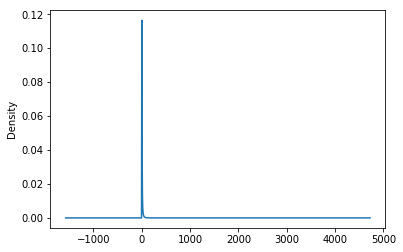

In [7]:
a.loc[a.bounce_visit==0.0,"total_pv"].plot(kind='density')

In [8]:
a.describe()

,total_visits,total_pv,max_pv,min_pv,anyBounces,totalBounce,total_hits,max_hits,min_hits,transactionRevenue,bouncesPerVisit,bounce_visit,cut_1,cut_2,cut_3,cut_4,cut_5,cut_6,cut_7,cut_8,cut_9,cut_10,cut_11,cut_12,cut_13,cut_14,cut_20,cut_30,cut_10000
count,587613.000000,587613.000000,587601.000000,587601.000000,587613.000000,587613.000000,587613.000000,587613.000000,587613.000000,587613.000000,587613.000000,587613.000000,587613.000000,587613.000000,587613.000000,587613.000000,587613.000000,587613.000000,587613.000000,587613.000000,587613.000000,587613.000000,587613.000000,587613.000000,587613.000000,587613.000000,587613.000000,587613.000000,587613.000000
mean,1.229302,4.729609,3.921741,3.013419,0.551278,0.613737,5.646587,4.687732,3.490777,0.246424,0.522518,0.495768,0.880831,0.077190,0.021618,0.008826,0.004299,0.002253,0.001399,0.000905,0.000577,0.000439,0.000315,0.000216,0.000189,0.000136,0.000441,0.000213,0.000153
std,1.247136,12.721865,7.270374,5.094021,0.497364,0.849419,16.702868,9.999607,6.922933,2.086380,0.486729,0.499983,0.323987,0.266893,0.145433,0.093529,0.065424,0.047414,0.037375,0.030076,0.024012,0.020949,0.017741,0.014700,0.013743,0.011667,0.020990,0.014584,0.012375
min,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,0.000000,0.666667,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,4.000000,4.000000,3.000000,1.000000,1.000000,4.000000,4.000000,3.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,226.000000,3148.000000,469.000000,466.000000,1.000000,141.000000,3869.000000,500.000000,500.000000,24.739237,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


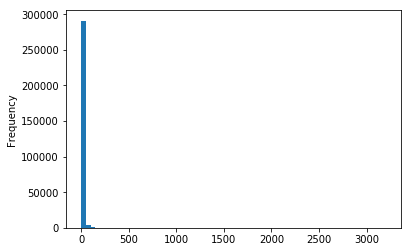

In [13]:
a.loc[a.bounce_visit==0.0,"total_pv"].plot(kind='hist',bins=[0,50,100,150,200,250,300,350,500,3200])

In [14]:
Counter(pd.cut(a.loc[a.bounce_visit==0.0,"total_pv"],bins=[0,50,100,150,200,250,300,350,500,3200]))

Counter({Interval(0, 50, closed='right'): 291196,
         Interval(50, 100, closed='right'): 3965,
         Interval(100, 150, closed='right'): 709,
         Interval(150, 200, closed='right'): 208,
         Interval(300, 350, closed='right'): 36,
         Interval(250, 300, closed='right'): 35,
         Interval(200, 250, closed='right'): 71,
         Interval(350, 500, closed='right'): 37,
         Interval(500, 3200, closed='right'): 24,
         nan: 12})

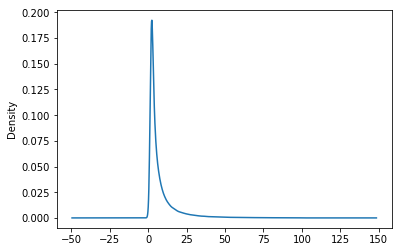

In [33]:
a.loc[(a.bounce_visit==0.0) & (a.total_pv<100),"total_pv"].plot(kind='density')

In [31]:
print(train_x.loc[train_x.pageviews==469,"fullVisitorId"])
train_x.loc[train_x.fullVisitorId=="743123551680199202",:]

321462    743123551680199202
Name: fullVisitorId, dtype: object


,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,bounces,hits,newVisits,pageviews,visits,browser,deviceCategory,operatingSystem,city,continent,country,metro,networkDomain,region,subContinent,campaign,isTrueDirect,medium,referralPath,source,transactionRevenue
321460,Social,2016-08-26,743123551680199202,743123551680199202_1472231409,1472231409,4,1472231409,NaN,218,NaN,202.0,1,Chrome,desktop,Windows,Maracaibo,Americas,Venezuela,(not set),cantv.net,Zulia,South America,(not set),True,referral,/,facebook.com,103820000.0
456166,Social,2016-08-25,743123551680199202,743123551680199202_1472160334,1472160334,2,1472160334,NaN,9,NaN,6.0,1,Chrome,desktop,Windows,Maracaibo,Americas,Venezuela,(not set),cantv.net,Zulia,South America,(not set),True,referral,/,facebook.com,NaN
456177,Social,2016-08-25,743123551680199202,743123551680199202_1472141727,1472141727,1,1472141727,NaN,21,1.0,16.0,1,Chrome,desktop,Windows,Maracaibo,Americas,Venezuela,(not set),cantv.net,Zulia,South America,(not set),NaN,referral,/,facebook.com,NaN
321462,Social,2016-08-26,743123551680199202,743123551680199202_1472216705,1472216705,3,1472216705,NaN,500,NaN,469.0,1,Chrome,desktop,Windows,Maracaibo,Americas,Venezuela,(not set),cantv.net,Zulia,South America,(not set),True,referral,/,facebook.com,90980000.0
585315,Social,2016-08-29,743123551680199202,743123551680199202_1472484710,1472484710,5,1472484710,1.0,1,NaN,1.0,1,Chrome,desktop,Windows,Maracaibo,Americas,Venezuela,(not set),cantv.net,Zulia,South America,(not set),True,referral,/,facebook.com,NaN


In [138]:
# a_subset=a.loc[a.bounce_visit==0,:]
# a_rest=a.loc[a.bounce_visit==1,:]
a_subset=a.copy()
print(a_subset.shape)
xg=xgb.XGBRegressor(n_jobs=-1,max_depth=7,n_estimators=100)
xg.fit(a_subset.drop('transactionRevenue',axis=1),a_subset.transactionRevenue)
yhat=xg.predict(a_subset.drop('transactionRevenue',axis=1))
print(rmse(a_subset.transactionRevenue,yhat))

(587613, 29)
1.6432973330097989


In [129]:
ne=a_rest.transactionRevenue.to_frame()
ne['predicted']=0
ne.columns=['true','predicted']
ne.head()

,true,predicted
fullVisitorId,,
0000062267706107999,0.0,0
0000085059828173212,0.0,0
0000114156543135683,0.0,0
0000197671390269035,0.0,0
0000253133284033056,0.0,0


In [130]:
ne.sum()

true         0.0
predicted    0.0
dtype: float64

In [131]:
err=pd.DataFrame({'true':a_subset.transactionRevenue,'predicted':yhat})
new=pd.concat([err,ne],axis=0)
new.shape

(587613, 2)

In [132]:
print(rmse(new.true,new.predicted))
print(rmse(err.true,err.predicted))

1.6385842120325078
2.3075640696107182


In [113]:
yhat[a.bounce_visit==1]=0
print(rmse(a.transactionRevenue,yhat))

1.643264520522226


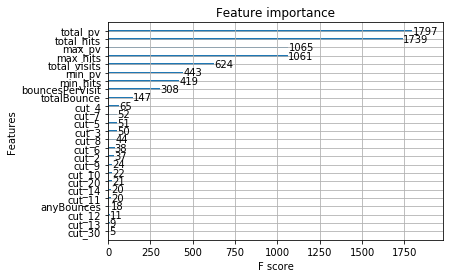

In [107]:
plot_importance(xg)

In [133]:
tr_y=process_train(pd.concat([test_x,test_y],axis=1))
tr_y.head()

/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4658: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,total_visits,total_pv,max_pv,min_pv,anyBounces,totalBounce,total_hits,max_hits,min_hits,transactionRevenue,bouncesPerVisit,bounce_visit,cut_1,cut_2,cut_3,cut_4,cut_5,cut_6,cut_7,cut_8,cut_9,cut_10,cut_11,cut_12,cut_13,cut_14,cut_20,cut_30,cut_10000
fullVisitorId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000176652019531658,1,1.0,1.0,1.0,1.0,1.0,1,1,1,0.000000,1.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0000213131142648941,1,13.0,13.0,13.0,0.0,0.0,14,14,14,17.329739,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
000026722803385797,1,2.0,2.0,2.0,0.0,0.0,3,3,3,0.000000,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0000419982866146379,1,1.0,1.0,1.0,1.0,1.0,1,1,1,0.000000,1.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0000436683523507380,1,2.0,2.0,2.0,0.0,0.0,2,2,2,0.000000,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Separated models

In [135]:
yhat_test=xg.predict(tr_y.drop('transactionRevenue',axis=1))
yhat_test[tr_y.bounce_visit==1]=0
print(rmse(tr_y.transactionRevenue,yhat_test))

1.7931132067010909


### Combined models

In [139]:
yhat_test=xg.predict(tr_y.drop('transactionRevenue',axis=1))
yhat_test[tr_y.bounce_visit==1]=0
print(rmse(tr_y.transactionRevenue,yhat_test))

1.7951855073452194


In [137]:
yhat_test[:5]

array([0.        , 1.4054995 , 0.00346553, 0.        , 0.00346553],
      dtype=float32)

In [41]:
def replace_values(column,lst_to_keep):
    def wrapper(data):
        data.loc[~data[column].isin(lst_to_keep),column]='other'
        return data
    return wrapper

def rp(data):
    column="referralPath"
    g=data.loc[(data[column].str.contains("/mail/u/0/"))| (data[column].str.contains("/mail/u/1/"))
               |(data[column].str.contains("google-merchandise-store")),column].unique()
    values_to_keep=['missing','/']+list(g)
    data.loc[~data[column].isin(values_to_keep),column]="others"
    data.loc[(data[column].str.contains("google-merchandise-store")),column]="gstore"
    data.loc[(data[column].str.contains("/mail/u/0/")),column]="mail0"
    data.loc[(data[column].str.contains("/mail/u/1/")),column]="mail0"
    return data

# train_x_c=rp(train_x.fillna({"referralPath":'missing'}) .copy())
# train_x_c.groupby('referralPath')['referralPath'].count()

# def cg(data):
#     column="channelGrouping"
#     values_to_keep=['Organic Search','Paid Search','Display']
#     data.loc[~data[column].isin(values_to_keep),column]="others"
#     return data

cg=replace_values(column="channelGrouping",lst_to_keep=['Organic Search','Paid Search','Display'])
# train_x_c=cg(train_x.fillna({"channelGrouping":'missing'}).copy())
# train_x_c.groupby('channelGrouping')['channelGrouping'].count()

# def source(data):
#     column="source"
#     values_to_keep=['google','yahoo','bing','dfa','(direct)','mail.googleplex.com','facebook.com','l.facebook.com','mail.google.com','dealspotr.com','sites.google.com']
#     data.loc[~data[column].isin(values_to_keep),column]="others"
#     return data

source=replace_values(column="source",lst_to_keep=['google','yahoo','bing','dfa','(direct)',
                                                   'mall.googleplex.com','facebook.com','l.facebook.com',
                                                   'mail.google.com','dealspotr.com','sites.google.com'])
# train_x_c=source(train_x.fillna({"source":'missing'}) .copy())
# train_x_c.groupby('source')['source'].count()

# def browser(data):
#     column="browser"
#     values_to_keep=['Chrome','Edge','Firefox','Internet Explorer','Safari']
#     data.loc[~data[column].isin(values_to_keep),column]="others"
#     return data

browser=replace_values(column="browser",lst_to_keep=['Chrome','Edge','Firefox','Internet Explorer','Safari'])
# train_x_c=browser(train_x.fillna({"browser":'missing'}) .copy())
# train_x_c.groupby('browser')['browser'].count()

os=replace_values(column='operatingSystem',lst_to_keep=['Linux','Macintosh','Windows','Chrome OS','Android','iOS'])
# train_x_c=os(train_x.fillna({"operatingSystem":'missing'}) .copy())
# train_x_c.groupby('operatingSystem')['operatingSystem'].count()

dc=replace_values(column='deviceCategory',lst_to_keep=['mobile','desktop'])
# train_x_c=dc(train_x.fillna({"deviceCategory":'missing'}) .copy())
# train_x_c.groupby('deviceCategory')['deviceCategory'].count()

city_r=replace_values(column="city",lst_to_keep=['not available in demo dataset','New York','Mountain View','San Francisco','Sunnyvale','Chicago','Los Angeles','Seattle','Austin','San Jose','Ann Arbor','Cambridge','Kirkland','Atlanta','San Bruno','Washington','Santa Clara','Toronto','Salem','Houston','(not set)','Palo Alto','Irvine','San Diego','Pittsburgh','Maracaibo','Dallas','Boulder','Fremont','Boston','Cupertino','Denver','Oakland','San Mateo','San Antonio','Jersey City','London'])


def interactions(df):
    values=[('rp_missing','source_google'),('rp_missing','source_yahoo'),('rp_missing','source_bing'),('rp_missing','source_dfa'),('rp_missing','source_(direct)'),('rp_/','source_mall.googleplex.com'),('rp_/','source_facebook.com'),('rp_/','source_l.facebook.com'),('rp_mail0','source_mail.google.com'),('rp_gstore','source_dealspotr.com'),('rp_gstore','source_sites.google.com'),('cg_Organic Search','source_google'),('cg_Paid Search','source_google'),('cg_Display','source_google'),('cg_Display','source_dfa'),('cg_Organic Search','source_bing'),('cg_Organic Search','source_yahoo'),('b_Chrome','os_Linux'),('b_Chrome','os_Macintosh'),('b_Chrome','os_Windows'),('b_Chrome','os_Chrome OS'),('b_Chrome','os_Android'),('b_Chrome','os_iOS'),('b_Firefox','os_Windows'),('b_Firefox','os_Macintosh'),('b_Internet Explorer','dc_mobile'),('b_Internet Explorer','dc_desktop'),('isTrueDirect','source_google'),('isTrueDirect','source_yahoo'),('isTrueDirect','source_bing'),('isTrueDirect','source_dfa'),('isTrueDirect','source_(direct)'),('isTrueDirect','source_mall.googleplex.com'),('isTrueDirect','source_facebook.com'),('isTrueDirect','source_l.facebook.com'),('isTrueDirect','source_mail.google.com'),('isTrueDirect','source_dealspotr.com'),('isTrueDirect','source_sites.google.com')]
    for i,j in values:
        df["{}_{}".format(i,j)]=df["{}".format(i)]*df["{}".format(j)]
    return df
        

def date_fe(train_x):
    train_x['weekday']=train_x['date'].apply(lambda x:'weekday_'+str(dt.datetime.weekday(x)))
    train_x['month']=train_x['date'].apply(lambda x:'month_'+str(x.month))
    train_x['quarter']=train_x['date'].apply(lambda x:'quarter_'+str(x.quarter))
    return train_x

In [42]:
train_x['order']=np.array(train_x['transactionRevenue']>0,dtype='float')
train_x=city_r(train_x)
city=train_x.groupby('city')['order','transactionRevenue'].agg(['sum','count'])
city_country=train_x.groupby(['city','country'])['order','transactionRevenue'].agg(['sum','count'])

city.columns=['_'.join(i) for i in city.columns.values.tolist()]
city_country.columns=["_".join(i) for i in city_country.columns.values.tolist()]

In [43]:
city['oc']=city.order_sum/city.order_count
city['tr_value']=city.transactionRevenue_sum/city.transactionRevenue_count
city.fillna(0,inplace=True)
city.reset_index(inplace=True)
city=city[['city','oc','tr_value']]
city_country['oc_cou']=city_country.order_sum/city_country.order_count
city_country['tr_value_cou']=city_country.transactionRevenue_sum/city_country.transactionRevenue_count
city_country.fillna(0,inplace=True)
city_country.reset_index(inplace=True)
city_country=city_country[['city','country','oc_cou','tr_value_cou']]
train_x.drop('order',axis=1,inplace=True)

In [60]:
def categorical_data(data):
    data.fillna({'referralPath':'missing','source':'missing',
                 'channelGrouping':'missing','operatingSystem':'missing',
                'browser':'missing','deviceCategory':'missing'},inplace=True)
    data=rp(data)
    data=cg(data)
    data=source(data)
    data=browser(data)
    data=os(data)
    data['isTrueDirect']=data['isTrueDirect'].apply(lambda x: 0 if np.isnan(x) else 1)
    data=date_fe(data)
    data=city_r(data)
    data=pd.get_dummies(data,columns=['referralPath','operatingSystem',
                                      'deviceCategory','browser','channelGrouping','source'
                                      ,'weekday','month','quarter'],
                       prefix=['rp','os','dc','b','cg','source','weekday','month','quarter'])
    data=interactions(data)
    data=data.merge(city,on='city',how='left')
    data=data.merge(city_country,on=['city','country'],how='left')
    data['city_oc']=data.apply(lambda x:x.oc_cou if x['city']=='not available in demo dataset' else x.oc,axis=1)
    data['city_mean']=data.apply(lambda x:x.tr_value_cou if x.city=='not available in demo dataset' else x.tr_value,axis=1)
    data.drop(['city','country','oc','tr_value','oc_cou','tr_value_cou'],axis=1,inplace=True)
#     data.drop(['oc','tr_value','oc_cou','tr_value_cou'],axis=1,inplace=True)
    return data
    
    

In [61]:
train_x_c=categorical_data(train_x.copy())

In [23]:
train_x_c.drop(['date','sessionId'])

,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,bounces,hits,newVisits,pageviews,visits,isTrueDirect,transactionRevenue,rp_/,rp_gstore,rp_mail0,rp_missing,rp_others,os_Android,os_Chrome OS,os_Linux,os_Macintosh,os_Windows,os_iOS,os_other,dc_desktop,dc_mobile,dc_tablet,b_Chrome,b_Edge,b_Firefox,b_Internet Explorer,b_Safari,b_other,cg_Display,cg_Organic Search,cg_Paid Search,cg_other,source_(direct),source_bing,source_dealspotr.com,source_dfa,source_facebook.com,source_google,source_l.facebook.com,source_mail.google.com,source_mall.googleplex.com,source_other,source_sites.google.com,source_yahoo,weekday_weekday_0,weekday_weekday_1,weekday_weekday_2,weekday_weekday_3,weekday_weekday_4,weekday_weekday_5,weekday_weekday_6,month_month_1,month_month_10,month_month_11,month_month_12,month_month_2,month_month_3,month_month_4,month_month_5,month_month_6,month_month_7,month_month_8,month_month_9,quarter_quarter_1,quarter_quarter_2,quarter_quarter_3,quarter_quarter_4,rp_missing_source_google,rp_missing_source_yahoo,rp_missing_source_bing,rp_missing_source_dfa,rp_missing_source_(direct),rp_/_source_mall.googleplex.com,rp_/_source_facebook.com,rp_/_source_l.facebook.com,rp_mail0_source_mail.google.com,rp_gstore_source_dealspotr.com,rp_gstore_source_sites.google.com,cg_Organic Search_source_google,cg_Paid Search_source_google,cg_Display_source_google,cg_Display_source_dfa,cg_Organic Search_source_bing,cg_Organic Search_source_yahoo,b_Chrome_os_Linux,b_Chrome_os_Macintosh,b_Chrome_os_Windows,b_Chrome_os_Chrome OS,b_Chrome_os_Android,b_Chrome_os_iOS,b_Firefox_os_Windows,b_Firefox_os_Macintosh,b_Internet Explorer_dc_mobile,b_Internet Explorer_dc_desktop,isTrueDirect_source_google,isTrueDirect_source_yahoo,isTrueDirect_source_bing,isTrueDirect_source_dfa,isTrueDirect_source_(direct),isTrueDirect_source_mall.googleplex.com,isTrueDirect_source_facebook.com,isTrueDirect_source_l.facebook.com,isTrueDirect_source_mail.google.com,isTrueDirect_source_dealspotr.com,isTrueDirect_source_sites.google.com,city_oc,city_mean
816737,2017-02-21,1293378929045822313,1293378929045822313_1487695260,1487695260,1,1487695260,1.0,1,1.0,1.0,1,0,NaN,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.001649,1.002207e+08
342187,2016-08-09,68476584980137026,68476584980137026_1470796098,1470796098,4,1470796098,NaN,20,NaN,17.0,1,1,NaN,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.028607,1.002905e+08
276050,2016-12-01,8828490818783908610,8828490818783908610_1480590518,1480590518,1,1480590518,1.0,1,1.0,1.0,1,0,NaN,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.001649,1.002207e+08
427964,2017-06-05,5544963667389419458,5544963667389419458_1496654888,1496654888,2,1496654888,NaN,3,NaN,3.0,1,0,NaN,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.024208,1.380368e+08
510771,2017-05-05,3504801554745635229,3504801554745635229_1494048274,1494048274,1,1494048274,NaN,2,1.0,2.0,1,0,NaN,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000118,7.057000e+07


In [175]:
train_x_c.to_csv("processed_unsummarised.csv",index=False)

In [31]:
def process_train(train):
    aggr={
    'sessionId':{
        'total_visits':'nunique'
    },
    'pageviews':{
        'total_pv':'sum',
        'max_pv':'max',
        'min_pv':'min'
    },
    'bounces':{
        'anyBounces':'max',
        'totalBounce':'sum',
        
    },
    'hits':{
        'total_hits':'sum',
        'max_hits':'max',
        'min_hits':'min'
    },
    'transactionRevenue':{
        'transactionRevenue':'sum'
    }
    }
    num=train.fillna({"bounces":0}).groupby('fullVisitorId').agg(aggr)
    num.columns=num.columns.droplevel(level=0)
    num.fillna({'transactionRevenue':0},inplace=True)
    num['bouncesPerVisit']=num['totalBounce']/num['total_visits']
    num['bounce_visit']=np.array(num.totalBounce==num.total_visits,dtype="int")
    num['cut_visits']=pd.cut(num.total_visits,bins=list(np.arange(15))+[20,30,10000],right=True,labels=list(np.arange(1,15))+[20,30,10000])
    num['transactionRevenue']=np.log(num['transactionRevenue']+1)
    num=pd.get_dummies(num,prefix="cut",prefix_sep="_")
    train.fillna(0,inplace=True)
    mn=train.drop(['date','sessionId','visitId','visitNumber',
                'visitStartTime','bounces','hits','transactionRevenue','pageviews',
               'visits'],axis=1).groupby('fullVisitorId').mean()
    mn=mn.merge(num,left_index=True,right_index=True,how='left')
    return mn

In [32]:
trn_mn=process_train(train_x_c.copy())

/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4658: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [33]:
trn_mn.shape

(587613, 131)

In [34]:
trn_mn.head()

,newVisits,isTrueDirect,rp_/,rp_gstore,rp_mail0,rp_missing,rp_others,os_Android,os_Chrome OS,os_Linux,os_Macintosh,os_Windows,os_iOS,os_other,dc_desktop,dc_mobile,dc_tablet,b_Chrome,b_Edge,b_Firefox,b_Internet Explorer,b_Safari,b_other,cg_Display,cg_Organic Search,cg_Paid Search,cg_other,source_(direct),source_bing,source_dealspotr.com,source_dfa,source_facebook.com,source_google,source_l.facebook.com,source_mail.google.com,source_mall.googleplex.com,source_other,source_sites.google.com,source_yahoo,weekday_weekday_0,weekday_weekday_1,weekday_weekday_2,weekday_weekday_3,weekday_weekday_4,weekday_weekday_5,weekday_weekday_6,month_month_1,month_month_10,month_month_11,month_month_12,month_month_2,month_month_3,month_month_4,month_month_5,month_month_6,month_month_7,month_month_8,month_month_9,quarter_quarter_1,quarter_quarter_2,quarter_quarter_3,quarter_quarter_4,rp_missing_source_google,rp_missing_source_yahoo,rp_missing_source_bing,rp_missing_source_dfa,rp_missing_source_(direct),rp_/_source_mall.googleplex.com,rp_/_source_facebook.com,rp_/_source_l.facebook.com,rp_mail0_source_mail.google.com,rp_gstore_source_dealspotr.com,rp_gstore_source_sites.google.com,cg_Organic Search_source_google,cg_Paid Search_source_google,cg_Display_source_google,cg_Display_source_dfa,cg_Organic Search_source_bing,cg_Organic Search_source_yahoo,b_Chrome_os_Linux,b_Chrome_os_Macintosh,b_Chrome_os_Windows,b_Chrome_os_Chrome OS,b_Chrome_os_Android,b_Chrome_os_iOS,b_Firefox_os_Windows,b_Firefox_os_Macintosh,b_Internet Explorer_dc_mobile,b_Internet Explorer_dc_desktop,isTrueDirect_source_google,isTrueDirect_source_yahoo,isTrueDirect_source_bing,isTrueDirect_source_dfa,isTrueDirect_source_(direct),isTrueDirect_source_mall.googleplex.com,isTrueDirect_source_facebook.com,isTrueDirect_source_l.facebook.com,isTrueDirect_source_mail.google.com,isTrueDirect_source_dealspotr.com,isTrueDirect_source_sites.google.com,city_oc,city_mean,total_visits,total_pv,max_pv,min_pv,anyBounces,totalBounce,total_hits,max_hits,min_hits,transactionRevenue,bouncesPerVisit,bounce_visit,cut_1,cut_2,cut_3,cut_4,cut_5,cut_6,cut_7,cut_8,cut_9,cut_10,cut_11,cut_12,cut_13,cut_14,cut_20,cut_30,cut_10000
fullVisitorId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000010278554503158,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,1,8.0,8.0,8.0,0.0,0.0,11,11,11,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0000020424342248747,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001649,1.002207e+08,1,13.0,13.0,13.0,0.0,0.0,17,17,17,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0000027376579751715,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.024208,1.380368e+08,1,5.0,5.0,5.0,0.0,0.0,6,6,6,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0000039460501403861,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [35]:
trn_mn.to_csv("regr_data")

In [30]:
train_x_c[train_x_c.fullVisitorId=="0000010278554503158"]

,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,bounces,hits,newVisits,pageviews,visits,isTrueDirect,transactionRevenue,rp_/,rp_gstore,rp_mail0,rp_missing,rp_others,os_Android,os_Chrome OS,os_Linux,os_Macintosh,os_Windows,os_iOS,os_other,dc_desktop,dc_mobile,dc_tablet,b_Chrome,b_Edge,b_Firefox,b_Internet Explorer,b_Safari,b_other,cg_Display,cg_Organic Search,cg_Paid Search,cg_other,source_(direct),source_bing,source_dealspotr.com,source_dfa,source_facebook.com,source_google,source_l.facebook.com,source_mail.google.com,source_mall.googleplex.com,source_other,source_sites.google.com,source_yahoo,weekday_weekday_0,weekday_weekday_1,weekday_weekday_2,weekday_weekday_3,weekday_weekday_4,weekday_weekday_5,weekday_weekday_6,month_month_1,month_month_10,month_month_11,month_month_12,month_month_2,month_month_3,month_month_4,month_month_5,month_month_6,month_month_7,month_month_8,month_month_9,quarter_quarter_1,quarter_quarter_2,quarter_quarter_3,quarter_quarter_4,rp_missing_source_google,rp_missing_source_yahoo,rp_missing_source_bing,rp_missing_source_dfa,rp_missing_source_(direct),rp_/_source_mall.googleplex.com,rp_/_source_facebook.com,rp_/_source_l.facebook.com,rp_mail0_source_mail.google.com,rp_gstore_source_dealspotr.com,rp_gstore_source_sites.google.com,cg_Organic Search_source_google,cg_Paid Search_source_google,cg_Display_source_google,cg_Display_source_dfa,cg_Organic Search_source_bing,cg_Organic Search_source_yahoo,b_Chrome_os_Linux,b_Chrome_os_Macintosh,b_Chrome_os_Windows,b_Chrome_os_Chrome OS,b_Chrome_os_Android,b_Chrome_os_iOS,b_Firefox_os_Windows,b_Firefox_os_Macintosh,b_Internet Explorer_dc_mobile,b_Internet Explorer_dc_desktop,isTrueDirect_source_google,isTrueDirect_source_yahoo,isTrueDirect_source_bing,isTrueDirect_source_dfa,isTrueDirect_source_(direct),isTrueDirect_source_mall.googleplex.com,isTrueDirect_source_facebook.com,isTrueDirect_source_l.facebook.com,isTrueDirect_source_mail.google.com,isTrueDirect_source_dealspotr.com,isTrueDirect_source_sites.google.com,city_oc,city_mean
230774,2016-10-20,0000010278554503158,0000010278554503158_1477029466,1477029466,1,1477029466,NaN,11,1.0,8.0,1,0,NaN,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,NaN


In [37]:
a_subset=trn_mn.copy()
print(a_subset.shape)
xg=xgb.XGBRegressor(n_jobs=-1,max_depth=7,n_estimators=100)
xg.fit(a_subset.drop('transactionRevenue',axis=1),a_subset.transactionRevenue)
yhat=xg.predict(a_subset.drop('transactionRevenue',axis=1))
print(rmse(a_subset.transactionRevenue,yhat))

(587613, 131)


NameError: name 'rmse' is not defined

In [17]:
def create_interactions(column_list,data):
    column_to_subset=list(set(data.columns).intersection(column_list))
    df_subset=data[column_to_subset]
    df_subset.fillna("missing",inplace=True)
    df=pd.get_dummies(df_subset,prefix=column_to_subset,prefix_sep="_")
    values=list()
    for cl in column_list:
        values.append(list(data[cl].unique()))
    for i,j in itr.product(values[0],values[1]):
        df["{}_{}_{}_{}".format(column_list[0],i,column_list[1],j)]=df["{}_{}".format(column_list[0],i)]*df["{}_{}".format(column_list[1],j)]
    data=pd.concat([data,df_subset,df],axis=1)
    return data